# Word Prediction


In this project, we will make a neural network that can predict the next word
in a sentence given the previous three.  
In doing this prediction task, our neural networks will learn about *words* and about
how to represent words. We'll explore the *vector representations* of words that our
model produces, and analyze these representations.


In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## 1. Data 

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Intro to DL/Assignment 2/ raw_sentences.txt' # TODO - UPDATE ME!

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [5]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [6]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use `10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [7]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]


**Display** 10 sentences in the training set.


In [8]:
print(*train[10:20],sep= "\n")

['but', 'for', 'me', ',', 'now', ',', 'this', 'is', 'it', '.']
['she', "'s", 'still', 'there', 'for', 'us', '.']
['it', "'s", 'part', 'of', 'this', 'game', ',', 'man', '.']
['it', 'was', ':', 'how', 'do', 'we', 'get', 'there', '?']
['but', 'they', 'do', 'nt', 'last', 'too', 'long', '.']
['more', 'are', 'like', 'me', ',', 'she', 'said', '.']
['who', 'do', 'you', 'think', 'they', 'want', 'to', 'be', 'like', '?']
['no', ',', 'he', 'could', 'not', '.']
['so', 'i', 'left', 'it', 'up', 'to', 'them', '.']
['we', 'were', 'nt', 'right', '.']



*We can see in the cell above that puncuations are treated as words in our word representation (ie they are individual items in a sentence list). We also see that words with apostrophes (such as she's in the 2nd sentence and it's in the 3rd, are broken up into 2 seperate word where the segment of the word up until the apostrophe (not including) is considered one word and the segment after the apostrophe (not including) is considered another*


**Print** the 10 most common words in the vocabulary and how often does each of these
words appear in the training sentences. Express the second quantity as a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are useful quantities to compute, because one of the first things a machine learning model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.


In [10]:

vocab_counter = collections.Counter([w for s in sentences for w in s])
most_common_vocab = vocab_counter.most_common(10)
train_vocab = [w for s in train for w in s]
for w in most_common_vocab:
  train_counter_curr_word = train_vocab.count(w[0])
  print("%s - %.2f%%" % (w[0],100*(train_counter_curr_word)/len(train_vocab)))

. - 10.70%
it - 3.85%
, - 3.25%
i - 2.94%
do - 2.69%
to - 2.58%
nt - 2.16%
? - 2.14%
the - 2.09%
that - 2.09%



Our neural network will take as input three words and predict the next one. Therefore, we need our data set to be comprised of seuqnces of four consecutive words in a sentence, referred to as *4grams*. 



In [11]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'], ['other', 'one', 'since', 'yesterday'], ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    
    matched_index = []
    idx_curr_sent = []
    
    for sent in sents:
      for word in sent:
        idx_curr_sent.append(vocab_stoi[word])
        
      matched_index.append(idx_curr_sent)
      idx_curr_sent = []
        
    return matched_index

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    four_grams = []
    
    for seq in seqs:
      for i in range(len(seq)-3):
        four_grams.append(seq[i:i+4])
        
    return four_grams

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)


# We can now generate our data which will be used to train and test the network
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

## 2. A Multi-Layer Perceptron

In this section, we will build a two-layer multi-layer perceptron. 
Our model will look like this:

<img src="https://drive.google.com/uc?id=15uMLB-YsMHSOr0EQfTRhWd4o9enIOjUe">

Since the sentences in the data are comprised of $250$ distinct words, our task boils down to claissfication where the label space $\mathcal{S}$ is of cardinality $|\mathcal{S}|=250$ while our input, which is comprised of a combination of three words, is treated as a vector of size $750\times 1$ (i.e., the concatanation of three one-hot $250\times 1$ vectors).

The following function `get_batch` will take as input the whole dataset and output a single batch for the training. The output size of the batch is explained below.


In [12]:
def make_onehot(data):
    """
    Convert one batch of data in the index notation into its corresponding onehot
    notation. Remember, the function should work for both xt and st. 
     
    input - vector with shape D (1D or 2D)
    output - vector with shape (D,250)
    """
 
    data_dim = np.shape(data);
    if len(data_dim) == 1: # 1D input
      data = np.expand_dims(data, axis = 0)
    
    data_dim = np.shape(data)
    one_hot_encode = np.zeros([data_dim[0], data_dim[1], 250], dtype = int)
    
    for i_sent in range(data_dim[0]):
      for i_word in range(data_dim[1]):
        curr_word = data[i_sent, i_word]
        one_hot_encode[i_sent, i_word, curr_word] = 1
        
    return one_hot_encode

def get_batch(data, range_min, range_max, onehot=True):
#     """
#     Convert one batch of data in the form of 4-grams into input and output
#     data and return the training data (xt, st) where:
#      - `xt` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
#      - `st` is either
#             - a numpy array of shape [batch_size, 250] if onehot is True,
#             - a numpy array of shape [batch_size] containing indicies otherwise

#     Preconditions:
#      - `data` is a numpy array of shape [N, 4] produced by a call
#         to `process_data`
#      - range_max > range_min
#     """
    
    xt = data[range_min:range_max, :3]
    xt = make_onehot(xt)   
    st = data[range_min:range_max, 3]
    if onehot:
        st = make_onehot(st).reshape(-1, 250)
    return xt, st




We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. 



In [13]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_hidden=400):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(750, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
    def forward(self, inp):
        inp = inp.reshape([-1, 750])
        # Note that we will be using the nn.CrossEntropyLoss(), which computes the softmax operation internally, as loss criterion
        hidden_layer = torch.relu(self.layer1(inp))
        output_layer = self.layer2(hidden_layer)
        return output_layer



We next  train the PyTorch model using the Adam optimizer and the cross entropy loss.


In [14]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xt, st = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        y = model(torch.Tensor(xt))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == st)
        N += st.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xt, st = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xt = torch.Tensor(xt)
            st = torch.Tensor(st).long()

            zs = model.forward(xt)     # compute prediction logit
            loss = criterion(zs,st)    # compute the total loss
            optimizer.zero_grad()      # a clean up step for PyTorch
            loss.backward()            # compute updates for each parameter
            optimizer.step()           # make the updates for each parameter
            

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.515147]
Iter 500. [Val Acc 31%] [Train Acc 32%, Loss 3.000866]
Iter 1000. [Val Acc 33%] [Train Acc 34%, Loss 2.781315]
Iter 1500. [Val Acc 34%] [Train Acc 36%, Loss 2.812083]
Iter 2000. [Val Acc 35%] [Train Acc 36%, Loss 2.647151]
Iter 2500. [Val Acc 35%] [Train Acc 37%, Loss 2.570235]
Iter 3000. [Val Acc 36%] [Train Acc 38%, Loss 2.571133]
Iter 3500. [Val Acc 36%] [Train Acc 38%, Loss 2.568099]
Iter 4000. [Val Acc 36%] [Train Acc 39%, Loss 2.550964]
Iter 4500. [Val Acc 37%] [Train Acc 39%, Loss 2.629879]
Iter 5000. [Val Acc 37%] [Train Acc 39%, Loss 2.536025]


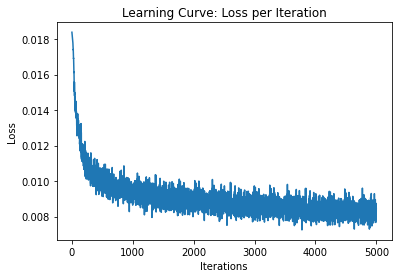

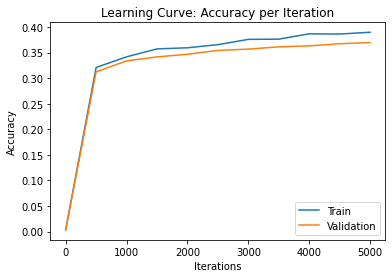

In [15]:
pytorch_mlp = PyTorchMLP()

learning_curve_info = run_pytorch_gradient_descent(model=pytorch_mlp,
                                                   train_data=train4grams,
                                                   validation_data=valid4grams,
                                                   batch_size=300,
                                                   learning_rate=0.001,
                                                   max_iters=5000)

plot_learning_curve(*learning_curve_info)

### Successful hyperparameter combinations:
1. learning rate = $10^{-3}$, batch size = 100, max iterations = 10,000 val - 37%, train - 39%.
2. learning rate = $10^{-3}$, batch size = 500, max iterations = 5,000 val - 37%, train - 40%.
**3. learning rate = $10^{-3}$, batch size = 300, max iterations = 5,000 val - 37%, train - 39%. - This configuration shows the best training and validation accuracy along with the shortest computation time**
4. learning rate = $5\cdot 10^{-3}$, batch size = 100, max iterations = 10,000 val - 36%, train - 41%. - This configuration shows some overfitting
4. learning rate = $2\cdot 10^{-3}$, batch size = 70, max iterations = 10,000 val - 37%, train - 39%. - This configuration also shows some overfitting

In [16]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PYTorchMLP.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos
  
    end_sentence = [vocab_stoi[word] for word in sentence[-3:]]
    end_sentence = make_onehot(end_sentence)
    end_sentence = torch.Tensor(end_sentence)
    pred = model(end_sentence)
    return vocab_itos[np.argmax(pred.detach().numpy())]

    
# make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])


Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"


In many cases where you overfit the model can either output the same results for all inputs or just memorize the dataset. 





In [23]:

sentences = [['you','are','a'],
             ['few', 'companies', 'show'],
             ['there','are','no'],
             ['yesterday', 'i','was'],
             ['the', 'game', 'had'],
             ['yesterday','the','federal'],
             ]
for sent in sentences:
  print(*sent, make_prediction_torch(pytorch_mlp, sent))




you are a good
few companies show .
there are no other
yesterday i was nt
the game had to
yesterday the federal government



The predictions our model are highlighted below:
- "You are a **good**"
- "few companies show **.**"
- "There are no **other**"
- "yesterday i was **nt**"
- "the game had **to**"
- "yesterday the federal **government**"

Looking at the above predictions, they all seem to make sense. we even see an example of a prediction of a word with an apostraphe: "yesterday i was **nt**"

Regarding overfitting, we gave some examples of hyperparameters which case a form of overfitting (a rising difference between the validation and test accuracy) in the cells above.


Report the test accuracy of your model

In [19]:
test_acuuracy = estimate_accuracy_torch(pytorch_mlp, test4grams)
print("Test Acc: %.2f%%" % (test_acuuracy*100))

Test Acc: 37.07%


## 3. Learning Word Embeddings

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://drive.google.com/uc?id=16lXygLTSuRgOCj6UWK0vHkSoyRJWfMSZ" />
 

This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases.
 

Iter 0. [Val Acc 2%] [Train Acc 2%, Loss 5.522215]
Iter 500. [Val Acc 29%] [Train Acc 30%, Loss 3.031385]
Iter 1000. [Val Acc 32%] [Train Acc 33%, Loss 2.987601]
Iter 1500. [Val Acc 33%] [Train Acc 34%, Loss 2.876938]
Iter 2000. [Val Acc 34%] [Train Acc 35%, Loss 2.668610]
Iter 2500. [Val Acc 35%] [Train Acc 36%, Loss 2.535786]
Iter 3000. [Val Acc 35%] [Train Acc 36%, Loss 2.607798]
Iter 3500. [Val Acc 36%] [Train Acc 36%, Loss 2.683799]
Iter 4000. [Val Acc 36%] [Train Acc 37%, Loss 2.596162]
Iter 4500. [Val Acc 36%] [Train Acc 37%, Loss 2.551008]
Iter 5000. [Val Acc 36%] [Train Acc 38%, Loss 2.548457]
Iter 5500. [Val Acc 36%] [Train Acc 38%, Loss 2.587978]
Iter 6000. [Val Acc 37%] [Train Acc 38%, Loss 2.631834]
Iter 6500. [Val Acc 37%] [Train Acc 38%, Loss 2.569036]
Iter 7000. [Val Acc 37%] [Train Acc 39%, Loss 2.527127]
Iter 7500. [Val Acc 37%] [Train Acc 39%, Loss 2.467913]
Iter 8000. [Val Acc 37%] [Train Acc 39%, Loss 2.689333]
Iter 8500. [Val Acc 37%] [Train Acc 40%, Loss 2.373307

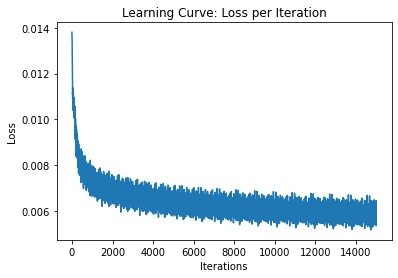

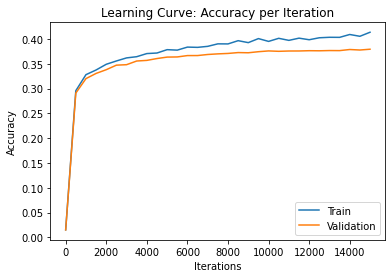

In [21]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)

pytorch_wordemb= PyTorchWordEmb()

result = run_pytorch_gradient_descent(pytorch_wordemb,
                                      max_iters=15000,
                                      train_data=train4grams,
                                      validation_data=valid4grams,
                                      batch_size=400,
                                      learning_rate=0.001)

plot_learning_curve(*result)


We use the function `make_prediction` that we wrote earlier to predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?


Results per hyperparameters:

- max_iter=10000, batch_size=400, learning_rate=0.001 -- val_acc=38%, train_acc=39% test_acc=37.76%
- max_iter=10000, batch_size=300, learning_rate=0.001 -- val_acc=37%, train_acc=40% test_acc=37.42%
- **max_iter=15000, batch_size=400, learning_rate=0.001 -- val_acc=38%, train_acc=41% test_acc=38.47%**

In [24]:
for sent in sentences:
  print(*sent, make_prediction_torch(pytorch_wordemb, sent))

you are a family
few companies show .
there are no children
yesterday i was nt
the game had to
yesterday the federal government


- "You are a **family**"
- "few companies show **.**"
- "There are no **children**"
- "yesterday i was **nt**"
- "the game had **to**"
- "yesterday the federal **government**"

We notice right away that the 1st and 3rd predictions are different from the original model, while all of the predictions still make sense. Towards the end of the training we see the beginnings of overfitting in our model as the difference between the training and validation accuracies rose to 3% (as opposed to 2% in the previous model). However, upon checking the test accuracy, we see that this model preforms better than the 1st.

Report the test accuracy of your model

In [25]:

test_acuuracy = estimate_accuracy_torch(pytorch_wordemb, test4grams)
print("Test Acc: %.2f%%" % (test_acuuracy*100))


Test Acc: 38.34%


##  4. Visualizing Word Embeddings

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings, which are a key concept in natural language processing.

%

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [29]:
word_emb_weights = list(pytorch_wordemb.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T


Since we input a single one-hot word at a time into the embedded layer, and due to the fact that each one-hot word is orthogonal to the rest of the words, then the vector multiplication of each row in the resulting weights is orthogonal to the other rows. Due to this, each row of the weights can only represent a single word from the input vocabulary.


One interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
the code below that computes the *cosine similarity* of
every pair of words in our vocabulary. This measure of similarity between vector ${\bf v}$ and ${\bf w}$ is defined as 
   $$d_{\rm cos}({\bf v},{\bf w}) = \frac{{\bf v}^T{\bf w}}{||{\bf v}|| ||{\bf w}||}.$$  We also pre-scale the vectors to have a unit norm, using Numpy's `norm` method.

In [30]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.07211699
-0.046547107


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [38]:

words_test = ['four', 'go','what','should','school','your','yesterday','not']
for word in words_test:
  curr_word_similarities = similarities[vocab_stoi[word]]
  curr_word_similarities[vocab_stoi[word]] = 0 #for not getting the word itself
  curr_word_similarities_sorted_idx = curr_word_similarities.argsort() #[min max]
  closest_words = [vocab_itos[w] for w in (curr_word_similarities_sorted_idx[-5:])]
  print((f"'{word}':  '{closest_words[0]}'  '{closest_words[1]}'   '{closest_words[2]}'   '{closest_words[3]}'   '{closest_words[4]}'"))

'four':  'five'  'those'   'group'   'two'   'three'
'go':  'money'  'off'   'back'   'going'   'come'
'what':  'world'  'where'   'who'   'when'   'how'
'should':  'will'  'may'   'might'   'would'   'could'
'school':  'him'  'program'   'before'   'off'   'week'
'your':  'our'  'their'   'his'   'its'   'my'
'yesterday':  'john'  'team'   'ago'   'season'   'year'
'not':  'is'  'to'   'among'   'never'   'nt'



We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


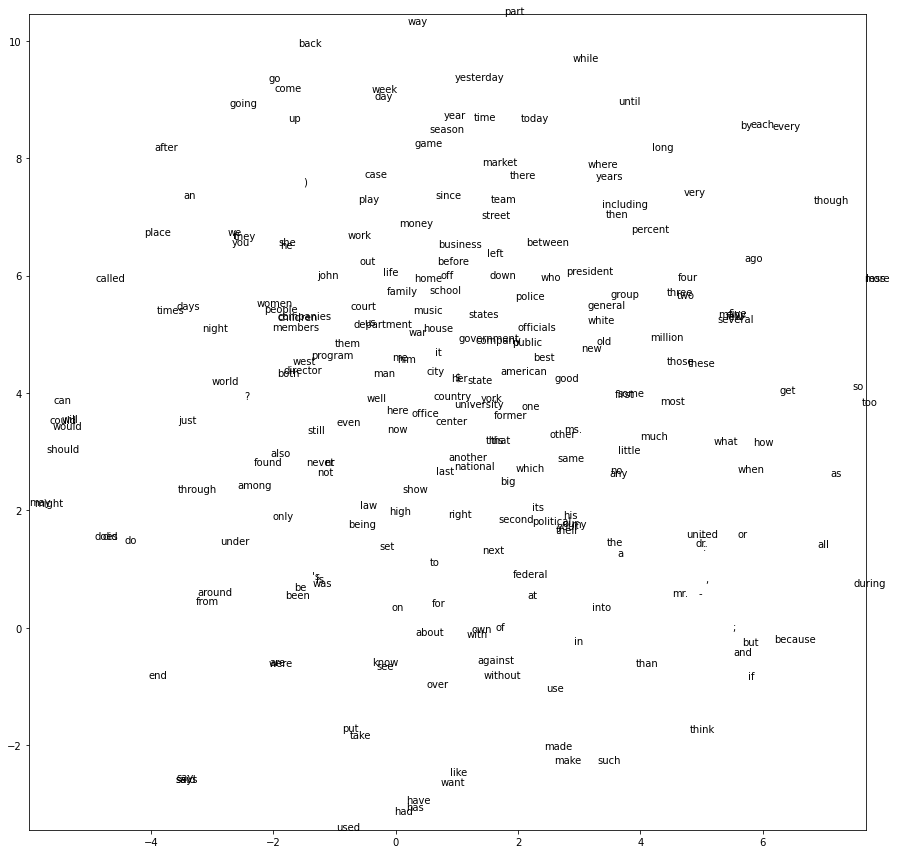

In [40]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(15, 15))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

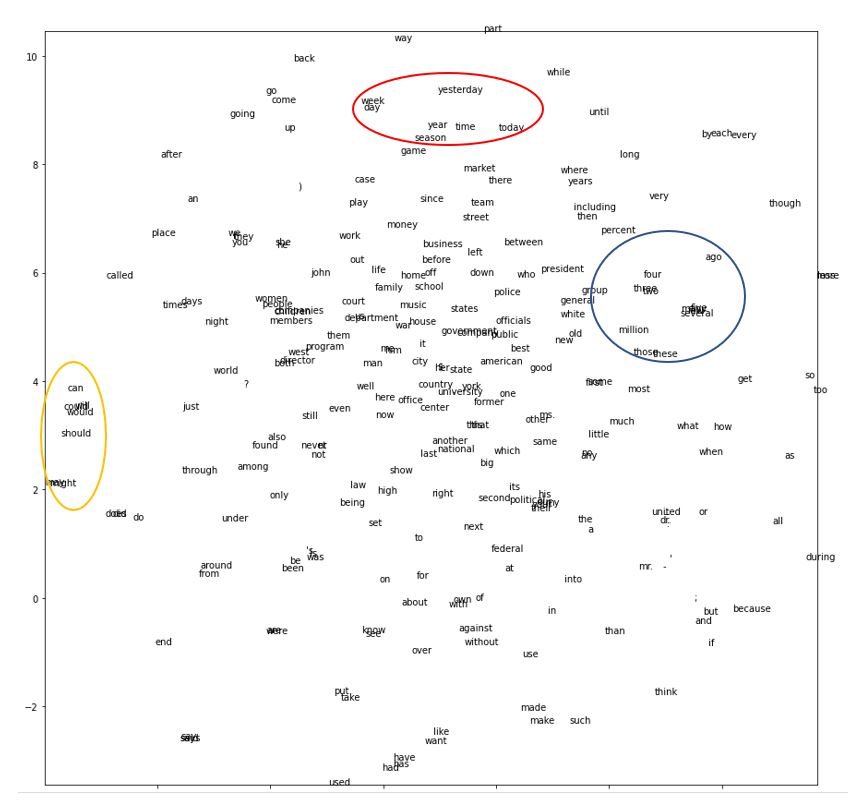

- In the blue cluster we see words connected to numbers and amounts - 'four', 'three', 'two', 'five', 'million', 'several', 'percent'
- In the red cluster we see temporal words - 'week', 'day', 'yesterday', 'year', 'season', 'time', 'today'
- In the orange cluster we see words connected to possibilities - 'can', 'could', 'may', 'might', 'would', 'will', 'should'
